In [32]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

Global configuration

In [34]:
TEST_SIZE = 0.2
RANDOM_SEED = 42
MODEL_FILENAME = 'type_on_title.pkl'

Load data

In [36]:
df = pd.read_csv('./data/training_data.csv')
df.dropna(subset=['Title', 'Type'], inplace=True) # drops rows with missing values
X = df['Title'].astype(str) # feature
y = df['Type'] # target label
print(f"Total samples: {len(X)}")

Total samples: 18087


Split into training and testing sets 

In [38]:
X_train, X_test, y_train, y_test = train_test_split( # shuffles and splits the data
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y # keeps same proportion of genre in training and testing sets
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples : {len(X_test)}")

Training samples: 14469
Testing samples : 3618


Pipeline: TF-IDF + Linear SVM

In [40]:
text_clf_svc = Pipeline([
    ('tfidf', TfidfVectorizer( # first applies a transformer 
        ngram_range=(1, 2),
        max_df=0.7, # ignores words appearing in more than 70% of the corpus
        stop_words='english'
    )),
    ('clf', LinearSVC( # then applies a classifier 
        C=1.0,
        class_weight='balanced', # adjusts for genres that are not well represented
        random_state=RANDOM_SEED
    )),
])

Training phase

In [42]:
text_clf_svc.fit(X_train, y_train)
print("Cross-validation on training set (5 folds):")
cv_scores = cross_val_score(text_clf_svc, X_train, y_train, cv=5) # divides the model in 5 folds and tests 5 times
print(f"Fold scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

Cross-validation on training set (5 folds):
Fold scores: [0.86592951 0.87456807 0.861783   0.86592951 0.85655029]
Mean CV accuracy: 0.8650


Testing phase

In [44]:
test_accuracy = text_clf_svc.score(X_test, y_test)
print(f"Final test accuracy: {test_accuracy:.4f}")
y_pred = text_clf_svc.predict(X_test) # predicts type for the test set

Final test accuracy: 0.8635


Classification report

In [46]:
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

      ballad       0.89      0.93      0.91        27
      comedy       0.93      0.86      0.89       104
       elegy       0.88      0.84      0.86        25
        hymn       1.00      0.88      0.93         8
       lines       0.84      0.95      0.89        22
       lyric       0.89      0.89      0.89        18
      melody       0.86      0.75      0.80         8
       novel       0.77      0.84      0.80       627
         ode       0.86      0.90      0.88       142
       opera       0.91      0.88      0.90        69
   pantomime       0.75      0.60      0.67         5
       parod       0.00      0.00      0.00         4
    pastoral       0.88      0.78      0.82         9
        play       0.86      0.86      0.86       123
        poet       0.91      0.88      0.90       643
  recitation       1.00      0.83      0.91         6
       rhyme       0.94      0.65      0.77        23
    

Normalized confusion matrix

In [48]:
labels = text_clf_svc.classes_
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels,
    normalize='true'
)
cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)
print("Normalized confusion matrix (rows = true labels):")
print(cm_df.round(2))

Normalized confusion matrix (rows = true labels):
            ballad  comedy  elegy  hymn  lines  lyric  melody  novel   ode  \
ballad        0.93    0.00   0.00  0.00   0.00   0.00    0.00   0.00  0.04   
comedy        0.00    0.86   0.00  0.00   0.00   0.00    0.00   0.07  0.00   
elegy         0.00    0.00   0.84  0.00   0.00   0.00    0.00   0.00  0.00   
hymn          0.00    0.00   0.00  0.88   0.00   0.00    0.00   0.00  0.00   
lines         0.00    0.00   0.00  0.00   0.95   0.00    0.00   0.00  0.00   
lyric         0.06    0.00   0.00  0.00   0.00   0.89    0.00   0.00  0.00   
melody        0.00    0.00   0.00  0.00   0.00   0.00    0.75   0.00  0.00   
novel         0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.84  0.01   
ode           0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.01  0.90   
opera         0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.03  0.00   
pantomime     0.00    0.00   0.00  0.00   0.00   0.00    0.00   0.00  0.00   
parod         

Plot the confusion matrix

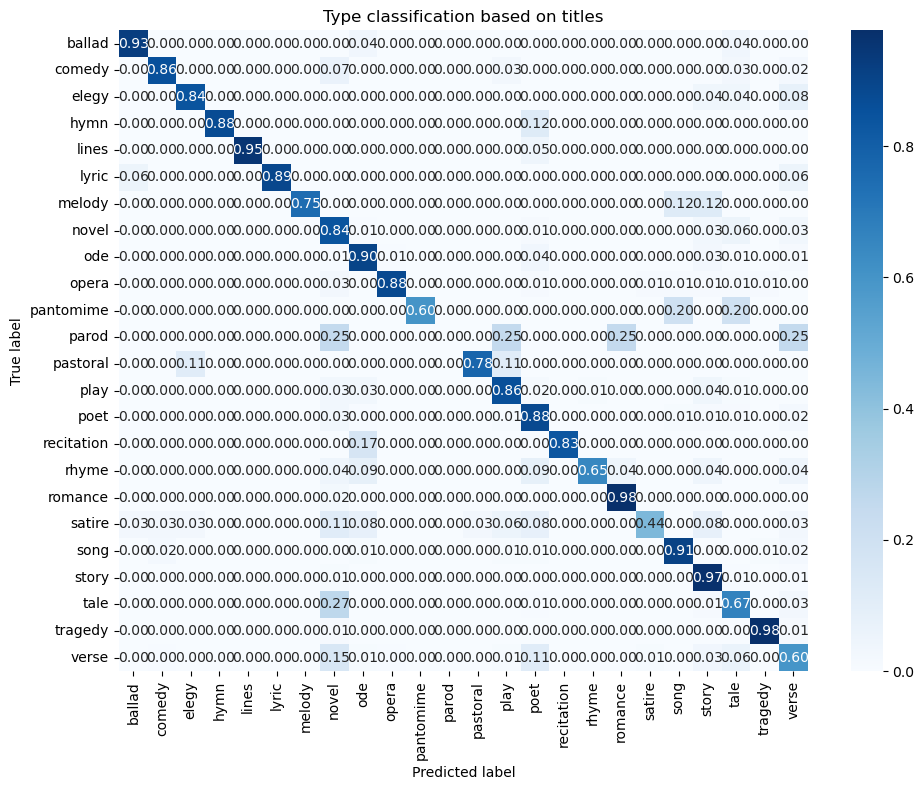

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Type classification based on titles")
plt.tight_layout()
plt.show()

Uncertainty measures, based on SVM decisions margin

In [52]:
decision_scores = text_clf_svc.decision_function(X_test) # gets decision score for each class
sorted_scores = np.sort(decision_scores, axis=1)
margins = sorted_scores[:, -1] - sorted_scores[:, -2] # margin uncertainty = difference between the highest and second highest score
uncertainty_df = pd.DataFrame({
    "true_label": y_test.values,
    "predicted_label": y_pred,
    "margin": margins
}).sort_values("margin")
print("Most uncertain predictions (lowest margins):")
print(uncertainty_df.head(10))

Most uncertain predictions (lowest margins):
     true_label predicted_label    margin
3373       song            song  0.000063
2869       poet            poet  0.000323
1194      novel           verse  0.000648
393        poet            song  0.000813
2852       tale            poet  0.001174
2321      novel           novel  0.001491
2171       song           verse  0.001512
911        tale           verse  0.001905
1227        ode           opera  0.001990
1057       poet            poet  0.002673


Plot the uncertainty measures

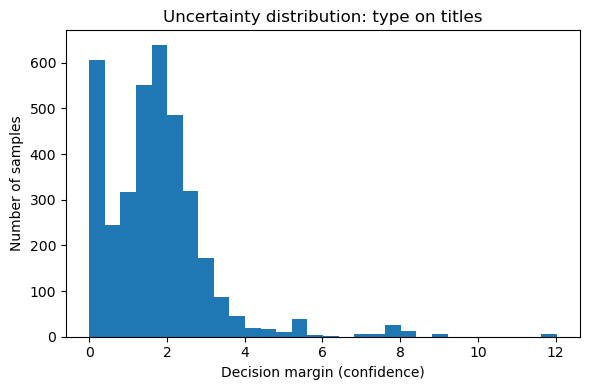

In [56]:
plt.figure(figsize=(6, 4))
plt.hist(margins, bins=30)
plt.xlabel("Decision margin (confidence)")
plt.ylabel("Number of samples")
plt.title("Uncertainty distribution: type on titles")
plt.tight_layout()
plt.show()

Save the model

In [58]:
joblib.dump(text_clf_svc, MODEL_FILENAME)
print(f"Model saved to: {MODEL_FILENAME}")

Model saved to: type_on_title.pkl
